In [120]:
%pip install scikit-image --quiet
%pip install numpy --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet
%pip install opencv-python --quiet
%pip install opencv-python-headless --quiet
%pip install opencv-contrib-python --quiet
%pip install scikit-learn --quiet
%pip install seaborn --quiet

]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111

In [121]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import filters

In [122]:
ORB_FEATURES = 1000
KNN = 5
ADD_ROTATION = False

In [123]:
data_train_dir = '../data/train'
data_test_dir = '../data/test'

# Load the images and keep the folder name as the label
def load_images(folder, n=None):
    images = []
    labels = []
    for label in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, label)):
            img = cv2.imread(os.path.join(folder, label, filename))
            if img is not None:
                images.append(img)
                labels.append(label)
            
            if n is not None and len(images) >= n:
                break
    return images, labels

images, labels = load_images(data_train_dir)
test_images, test_labels = load_images(data_test_dir)
# concat
images = images + test_images
labels = labels + test_labels

original_images = images.copy()

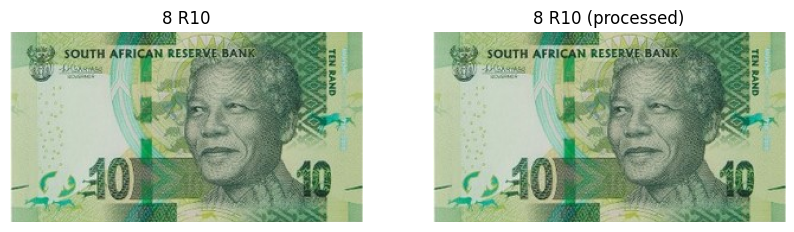

In [124]:
def display(images, labels, display_images):
    for i in display_images:
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        axarr[0].set_title(str(i) + ' ' + labels[i])
        axarr[0].axis('off')
        axarr[1].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axarr[1].set_title(str(i) + ' ' + labels[i] + ' (processed)')
        axarr[1].axis('off')
        plt.show()
display(images, labels, [8])

In [125]:
def preprocess(img):
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = cv2.resize(img, (574, 265))



    return img

preprocessed_imgs = [preprocess(img) for img in images]

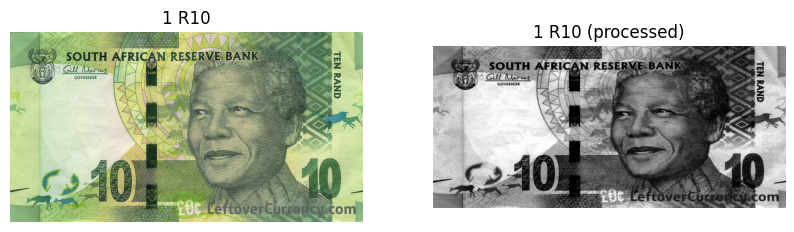

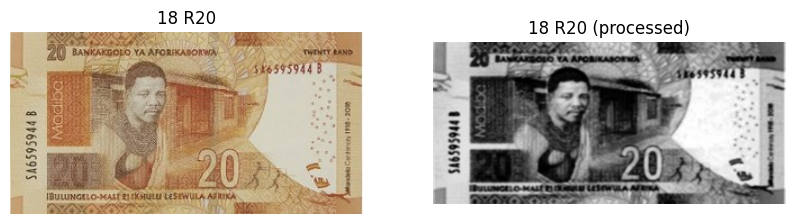

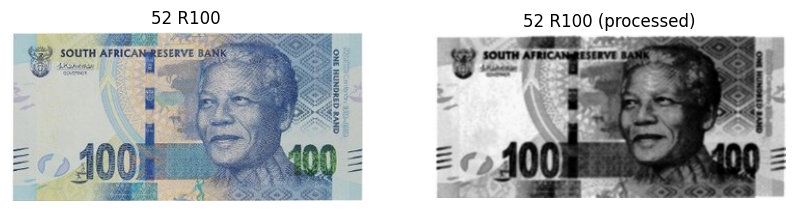

In [126]:
display(preprocessed_imgs, labels, [1,18,52])

In [127]:
def extract_features(img):
    orb = cv2.ORB_create(ORB_FEATURES)
    keypoints, descriptors = orb.detectAndCompute(img, None)
    return keypoints, descriptors

descriptors = [extract_features(img)[1] for img in preprocessed_imgs]

print('Number of descriptors:',len(descriptors))
print('All shapes:', [d.shape for d in descriptors])

Number of descriptors: 87
All shapes: [(969, 32), (977, 32), (958, 32), (972, 32), (969, 32), (969, 32), (953, 32), (966, 32), (966, 32), (971, 32), (974, 32), (903, 32), (936, 32), (975, 32), (973, 32), (948, 32), (955, 32), (970, 32), (947, 32), (975, 32), (962, 32), (968, 32), (977, 32), (965, 32), (966, 32), (982, 32), (973, 32), (967, 32), (973, 32), (969, 32), (961, 32), (982, 32), (957, 32), (964, 32), (965, 32), (965, 32), (957, 32), (946, 32), (975, 32), (976, 32), (989, 32), (977, 32), (964, 32), (980, 32), (910, 32), (979, 32), (963, 32), (957, 32), (956, 32), (980, 32), (969, 32), (933, 32), (972, 32), (982, 32), (944, 32), (970, 32), (949, 32), (973, 32), (973, 32), (973, 32), (950, 32), (934, 32), (959, 32), (971, 32), (967, 32), (977, 32), (968, 32), (967, 32), (974, 32), (971, 32), (966, 32), (972, 32), (934, 32), (972, 32), (971, 32), (974, 32), (825, 32), (799, 32), (972, 32), (979, 32), (971, 32), (964, 32), (934, 32), (839, 32), (909, 32), (527, 32), (972, 32)]


In [128]:
all_descriptors = np.vstack(descriptors)
labels = np.array(labels)

all_descriptors.shape, labels.shape

((82987, 32), (87,))

In [129]:
# clustering
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1000, random_state=42)
kmeans.fit(all_descriptors)

MiniBatchKMeans(n_clusters=1000, random_state=42)

In [130]:
# bag of words
def bag_of_words(descriptors, kmeans):
    histogram = np.zeros(kmeans.n_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

bovw = np.array([bag_of_words(d, kmeans) for d in descriptors])
bovw.shape

(87, 1000)

In [131]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Standardize the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(bovw)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=0)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [132]:
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

Classification Accuracy: 66.67%


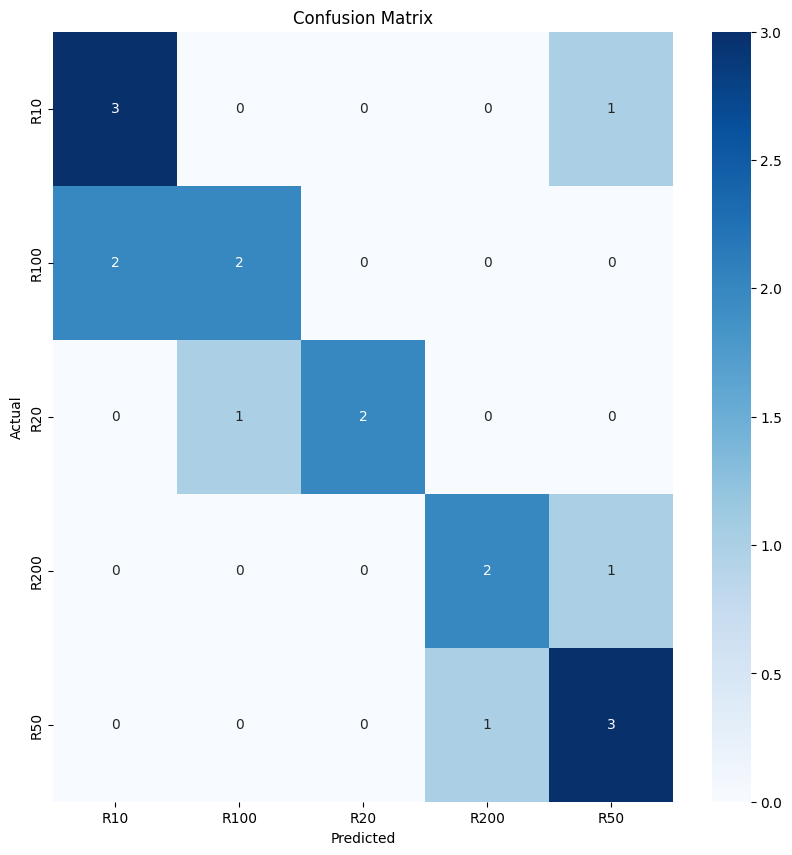

In [133]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
